# Detecting LLM Authorship

In this notebook, we do some data analysis to identify LLM authored vs Human authored text. We used the AuTexTification dataset. This dataset comes presplit with text across 5 domains: tweets, wiki, legal, reviews, and news.

The reviews and news domains were reserved for the test set, where tweets, wiki, and legal were used for the training dataset. Because the text in test dataset is so different from the train dataset, we in general expect to see a large drop in performance on the test dataset. To show performance on a test dataset on that was trained on data from the same domain, we create a holdout dataset using an 80/20 train-test split on the training dataset.

##### Load the data

We extracted the features for the data using all of the feature extraction functions in feature_extraction.py. We also removed any data point (from both the train and test sets) that had fewer than 10 words.

As extracting the features takes a few minutes, we have preprocessed the features using grab_feature.py and saved them. For each text, we extracted over 300 features! The feature engineering is where the bulk of the time was spent on this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



df_train = pd.read_csv(
    f"../Data/AuTextification/Features/features_train_df_subtask_one.csv"
    )

df_test = pd.read_csv(
    f"../Data/AuTextification/Features/features_test_df_subtask_one.csv"
    )





df_train = df_train.drop(columns = [col for col in df_train.columns if col.startswith("text.") or col.startswith("Unnamed")])

df_test = df_test.drop(columns = [col for col in df_test.columns if col.startswith("text.") or col.startswith("Unnamed")])


Temporary to add the labels

In [2]:
df_train_original = pd.read_csv(
    f"../Data/AuTextification/raw/subtask_one_train.tsv",
    sep="\t",
    header=0,
    index_col=0
)

df_test_original = pd.read_csv(
    f"../Data/AuTextification/raw/subtask_one_test.tsv",
    sep="\t",
    header=0,
    index_col=0
)




In [ ]:
from sklearn.model_selection import train_test_split


df_train = df_train.merge(df_train_original[["text", "label"]], on = "text", how = "left")
df_test = df_test.merge(df_test_original[["text", "label"]], on = "text", how = "left")


df_train, df_holdout, y_train, y_holdout = train_test_split(df_train, df_train["label"], test_size=0.2, stratify=df_train["label"])





### Exploratory data analysis and baseline models

We started by exploring our data, by looking at some simple features. 

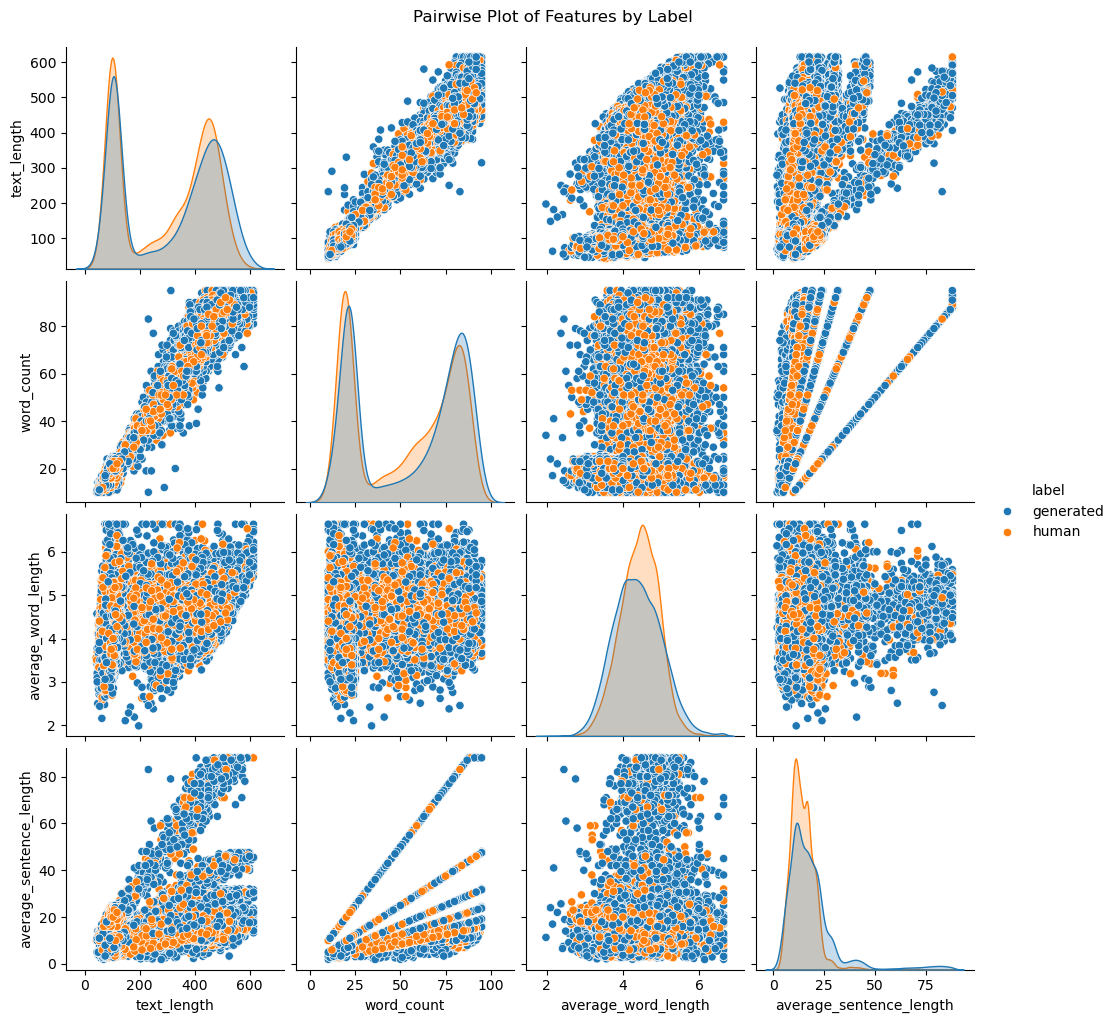

In [ ]:
#make pairwise plot of a few features


baseline_features = [
    "text_length",
    "word_count",
    "average_word_length",
    "average_sentence_length"
]

plot_df = df_train[baseline_features].copy()
plot_df["label"] = target


#first clip outliers
for feature in baseline_features:
    threshold = plot_df[feature].quantile(0.999)
    plot_df[feature] = plot_df[feature].clip(upper=threshold)
#normalize features

#plot pairwise plot
sns.pairplot(plot_df, hue="label", vars=baseline_features)
plt.suptitle("Pairwise Plot of Features by Label", y=1.02)
plt.show()



In the test set, about 52% of the examples are LLM generated. 

We can see some class separation already! We use these features for our baseline model. Our two baseline models are

1) Logistic regression
2) A random forest model
3) Predict majority label (Which has accuracy of 52%)

In training, we only used an 80/20 split on df_train where logistic regression achieved 58% accuracy and the random forest model achieved a 66% accuracy. We see similar performance on the holdout dataset.

For the test dataset, while the logistic regression baseline does about as well as in the training with an accuracy of around 55%, the random forest model does worse with an accuracy of only around 59%. 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

baseline_features = [
    "text_length",
    "word_count",
    "average_word_length",
    "average_sentence_length"
]   
X_train, X_holdout, X_test = df_train[baseline_features], df_holdout[baseline_features], df_test[baseline_features]

y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Evaluate the logistic regression model
y_pred_holdout_logistic = logistic_model.predict(X_holdout)
print("Logistic Regression Model on holdout data:")
print(classification_report(y_holdout, y_pred_holdout_logistic))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_logistic))

y_pred_test_logistic = logistic_model.predict(X_test)
print("Logistic Regression Model on test data:")
print(classification_report(y_test, y_pred_test_logistic))
print("Accuracy:", accuracy_score(y_test, y_pred_test_logistic))

print("\n")

# Train a LightGBM classifier
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(n_estimators=100, random_state=1)
lgbm_model.fit(X_train, y_train)

# Evaluate the LightGBM classifier
y_pred_holdout_lgbm = lgbm_model.predict(X_holdout)
print("LightGBM Classifier on holdout data:")
print(classification_report(y_holdout, y_pred_holdout_lgbm))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_lgbm))

y_pred_test_lgbm = lgbm_model.predict(X_test)
print("LightGBM Classifier on test data:")
print(classification_report(y_test, y_pred_test_lgbm))
print("Accuracy:", accuracy_score(y_test, y_pred_test_lgbm), "\n" * 3)


Logistic Regression Model on holdout data:
              precision    recall  f1-score   support

   generated       0.62      0.49      0.55      3332
       human       0.58      0.70      0.63      3390

    accuracy                           0.60      6722
   macro avg       0.60      0.60      0.59      6722
weighted avg       0.60      0.60      0.59      6722

Accuracy: 0.5961023504909253
Logistic Regression Model on test data:
              precision    recall  f1-score   support

   generated       0.58      0.47      0.52     11096
       human       0.53      0.63      0.57     10380

    accuracy                           0.55     21476
   macro avg       0.55      0.55      0.55     21476
weighted avg       0.55      0.55      0.55     21476

Accuracy: 0.5485192773328367


[LightGBM] [Info] Number of positive: 13558, number of negative: 13326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=

##### Audio features

One of hypotheses going into this project was that audio based features would be useful as we expect that humans use more audio information when writing than LLMs do. 

The audio feature that we focused on was vowel sounds. Using the _pronouncing_ library, we reduced texts to a sequence of 15 possible vowel sounds. The two classes of features we extracted from the sequences were the frequencies of each vowel sound and the frequencies of consecutive pairs of vowel sounds.

In the following cell, we train a model using **exclusively** these audio based features. In training, this model achieved approximately 68% accuracy. On the holdout dataset, this performed similarly with an accuracy of 69%. However, on the test dataset, this model achieves an accuracy of only 54%. This comes as a surprise as we expected audio features to generalize better across domains.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

# Train an LGBM classifier with only vowel sound frequencies and vowel sound pair frequencies
audio_features = [feature for feature in df_train.columns if feature.startswith("vowel_sound")]

X_train, X_holdout, X_test = df_train[audio_features], df_holdout[audio_features], df_test[audio_features]
y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train an LGBM classifier
lgbm_model = LGBMClassifier(n_estimators=100, random_state=1)
lgbm_model.fit(X_train, y_train)

# Evaluate the LGBM classifier on holdout set
y_pred_holdout_lgbm = lgbm_model.predict(X_holdout)
print("LGBM Classifier with Vowel Sound Features on holdout dataset:")
print(classification_report(y_holdout, y_pred_holdout_lgbm))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_lgbm))

# Evaluate the LGBM classifier on test set
y_pred_test_lgbm = lgbm_model.predict(X_test)
print("LGBM Classifier with Vowel Sound Features on test dataset:")
print(classification_report(y_test, y_pred_test_lgbm))
print("Accuracy:", accuracy_score(y_test, y_pred_test_lgbm))


[LightGBM] [Info] Number of positive: 13558, number of negative: 13326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44406
[LightGBM] [Info] Number of data points in the train set: 26884, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017260
[LightGBM] [Info] Start training from score 0.017260
LGBM Classifier with Vowel Sound Features on holdout dataset:
              precision    recall  f1-score   support

   generated       0.68      0.71      0.69      3332
       human       0.70      0.67      0.69      3390

    accuracy                           0.69      6722
   macro avg       0.69      0.69      0.69      6722
weighted avg       0.69      0.69      0.69      6722

Accuracy: 0.690717048497471
LGBM Classifier with Vowel Sound Features on test dataset:
              precision    rec

### Part of speech based features

We also extracted part of speech based features using the spaCy library. Here we train a model using only parts of speech and punctuation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier with only punctuation and part of speech features
POS_and_Punctuation_features = [
    feature for feature in df_train.columns 
    if feature.startswith("part_of_speech") or feature.startswith("punctuation")
]

X_train, X_holdout, X_test = df_train[POS_and_Punctuation_features], df_holdout[POS_and_Punctuation_features], df_test[POS_and_Punctuation_features]
y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest classifier on holdout set
y_pred_holdout_rf = rf_model.predict(X_holdout)
print("Random Forest Classifier with punctuation and part of speech features on holdout dataset:")
print(classification_report(y_holdout, y_pred_holdout_rf))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_rf))

# Evaluate the Random Forest classifier on test set
y_pred_test_rf = rf_model.predict(X_test)
print("Random Forest Classifier with punctuation and part of speech features on test dataset:")
print(classification_report(y_test, y_pred_test_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))


Random Forest Classifier with punctuation and part of speech features on holdout dataset:
              precision    recall  f1-score   support

   generated       0.73      0.76      0.74      3332
       human       0.75      0.72      0.74      3390

    accuracy                           0.74      6722
   macro avg       0.74      0.74      0.74      6722
weighted avg       0.74      0.74      0.74      6722

Accuracy: 0.7398095804819994
Random Forest Classifier with punctuation and part of speech features on test dataset:
              precision    recall  f1-score   support

   generated       0.58      0.81      0.67     11096
       human       0.64      0.36      0.46     10380

    accuracy                           0.59     21476
   macro avg       0.61      0.59      0.57     21476
weighted avg       0.61      0.59      0.57     21476

Accuracy: 0.5938722294654498


### Full model

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


all_features = [feature for feature in df_train.columns if not(feature.startswith("vowel_sound")) and feature not in ["text", "label"]]

X_train, X_holdout, X_test = df_train[all_features], df_holdout[all_features], df_test[all_features]
y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest classifier on holdout set
y_pred_holdout_rf = rf_model.predict(X_holdout)
print("Random Forest Classifier with punctuation and part of speech features on holdout dataset:")
print(classification_report(y_holdout, y_pred_holdout_rf))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_rf))

# Evaluate the Random Forest classifier on test set
y_pred_test_rf = rf_model.predict(X_test)
print("Random Forest Classifier with punctuation and part of speech features on test dataset:")
print(classification_report(y_test, y_pred_test_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))


Random Forest Classifier with punctuation and part of speech features on holdout dataset:
              precision    recall  f1-score   support

   generated       0.81      0.82      0.81      3332
       human       0.82      0.81      0.81      3390

    accuracy                           0.81      6722
   macro avg       0.81      0.81      0.81      6722
weighted avg       0.81      0.81      0.81      6722

Accuracy: 0.8146385004462957
Random Forest Classifier with punctuation and part of speech features on test dataset:
              precision    recall  f1-score   support

   generated       0.58      0.85      0.69     11096
       human       0.69      0.36      0.47     10380

    accuracy                           0.61     21476
   macro avg       0.64      0.60      0.58     21476
weighted avg       0.63      0.61      0.58     21476

Accuracy: 0.6098901098901099


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


all_features = [feature for feature in df_train.columns if not(feature.startswith("vowel_sound")) and feature not in ["text", "label"]]

X_train, X_holdout, X_test = df_train[all_features], df_holdout[all_features], df_test[all_features]
y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest classifier on holdout set
y_pred_holdout_rf = rf_model.predict(X_holdout)
print("Random Forest Classifier with punctuation and part of speech features on holdout dataset:")
print(classification_report(y_holdout, y_pred_holdout_rf))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_rf))

# Evaluate the Random Forest classifier on test set
y_pred_test_rf = rf_model.predict(X_test)
print("Random Forest Classifier with punctuation and part of speech features on test dataset:")
print(classification_report(y_test, y_pred_test_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Select features that start with "letter" or "punctuation"
all_features = [feature for feature in df_train.columns if feature.startswith("letter") or feature.startswith("punctuation")]

# Split the datasets
X_train, X_holdout, X_test = df_train[all_features], df_holdout[all_features], df_test[all_features]
y_train, y_holdout, y_test = df_train["label"], df_holdout["label"], df_test["label"]

# Train a Logistic Regression classifier
logistic_model = LogisticRegression(max_iter=1000, random_state=1)
logistic_model.fit(X_train, y_train)

# Evaluate the Logistic Regression classifier on holdout set
y_pred_holdout_logistic = logistic_model.predict(X_holdout)
print("Logistic Regression Classifier with punctuation and letter features on holdout dataset:")
print(classification_report(y_holdout, y_pred_holdout_logistic))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout_logistic))

# Evaluate the Logistic Regression classifier on test set
y_pred_test_logistic = logistic_model.predict(X_test)
print("Logistic Regression Classifier with punctuation and letter features on test dataset:")
print(classification_report(y_test, y_pred_test_logistic))
print("Accuracy:", accuracy_score(y_test, y_pred_test_logistic))


Logistic Regression Classifier with punctuation and letter features on holdout dataset:
              precision    recall  f1-score   support

   generated       0.63      0.66      0.64      3332
       human       0.65      0.61      0.63      3390

    accuracy                           0.64      6722
   macro avg       0.64      0.64      0.64      6722
weighted avg       0.64      0.64      0.64      6722

Accuracy: 0.6361202023207378
Logistic Regression Classifier with punctuation and letter features on test dataset:
              precision    recall  f1-score   support

   generated       0.56      0.70      0.62     11096
       human       0.56      0.41      0.47     10380

    accuracy                           0.56     21476
   macro avg       0.56      0.55      0.55     21476
weighted avg       0.56      0.56      0.55     21476

Accuracy: 0.5582045073570497


In [50]:
import uuid, pandas as pd, numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

#As lightgbm doesn't support special characters in feature names, we rename the features

all_features = [
    c for c in df_train.columns
    if not c.startswith("vowel_sound") and c not in ["text", "label"]
    ]

name_map = {orig: f"f_{uuid.uuid4().hex[:8]}" for orig in all_features}
safe_to_orig = {v: k for k, v in name_map.items()}   # reverse map

X_train  = df_train[all_features].rename(columns=name_map)
X_holdout = df_holdout[all_features].rename(columns=name_map)
X_test   = df_test[all_features].rename(columns=name_map)

y_train, y_holdout, y_test = (
    df_train["label"],
    df_holdout["label"],
    df_test["label"],
)


#The hyperparameters we used for tuning
# param_grid = {
#     "num_leaves":        [31, 63, 127],
#     "max_depth":         [-1, 8, 12],
#     "colsample_bytree":  [0.7, 0.9, 1.0],
#     "reg_alpha":         [0.0, 1.0],
#     "reg_lambda":        [0.0, 1.0],
#     "verbosity": [-1],

# }

#Best hyperparameters
param_grid = {
    "num_leaves":        [127],
    "max_depth":         [-1],
    "colsample_bytree":  [0.7],
    "reg_alpha":         [1.0],
    "reg_lambda":        [0.0],
    "verbosity": [-1],

}




cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

base_lgbm = LGBMClassifier(random_state=1, n_jobs=-1)

grid = GridSearchCV(
    estimator=base_lgbm,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)


grid.fit(X_train, y_train)

print(f"\nBest CV accuracy: {grid.best_score_:.4f}")
print("Best params:", grid.best_params_)

#refit on full training dataset
best_lgbm = grid.best_estimator_

print("Full model on holdout dataset")
y_pred_holdout = best_lgbm.predict(X_holdout)
print(classification_report(y_holdout, y_pred_holdout))
print("Accuracy:", accuracy_score(y_holdout, y_pred_holdout))

print("Full model on test dataset")
y_pred_test = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))

#record importances with original names
importances = (
    pd.Series(best_lgbm.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)
importances.index = importances.index.map(safe_to_orig)

print("\nTop 20 feature importances:")
print(importances.head(20))


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best CV accuracy: 0.8344
Best params: {'colsample_bytree': 0.7, 'max_depth': -1, 'num_leaves': 127, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'verbosity': -1}
Full model on holdout dataset
              precision    recall  f1-score   support

   generated       0.84      0.83      0.83      3332
       human       0.83      0.84      0.84      3390

    accuracy                           0.83      6722
   macro avg       0.83      0.83      0.83      6722
weighted avg       0.83      0.83      0.83      6722

Accuracy: 0.8338292174947932
Full model on test dataset
              precision    recall  f1-score   support

   generated       0.61      0.86      0.71     11096
       human       0.73      0.42      0.53     10380

    accuracy                           0.64     21476
   macro avg       0.67      0.64      0.62     21476
weighted avg       0.67      0.64      0.62     21476

Accuracy: 0.6428571428571429

Top 20 feature i

In [49]:
grid.best_params_

{'colsample_bytree': 0.7,
 'num_leaves': 127,
 'reg_alpha': 1.0,
 'reg_lambda': 0.0,
 'verbosity': -1}

In [51]:
print("Full model on test dataset")
y_pred_test = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_test, digits = 4))
print("Accuracy:", accuracy_score(y_test, y_pred_test))


Full model on test dataset
              precision    recall  f1-score   support

   generated     0.6101    0.8557    0.7123     11096
       human     0.7292    0.4153    0.5292     10380

    accuracy                         0.6429     21476
   macro avg     0.6696    0.6355    0.6208     21476
weighted avg     0.6676    0.6429    0.6238     21476

Accuracy: 0.6428571428571429
